In [2]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader
from tqdm import tqdm  # For nice progress bar!
import matplotlib.pyplot as plt

Load the Data

In [3]:
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)

In [4]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

Randomly Printing some images

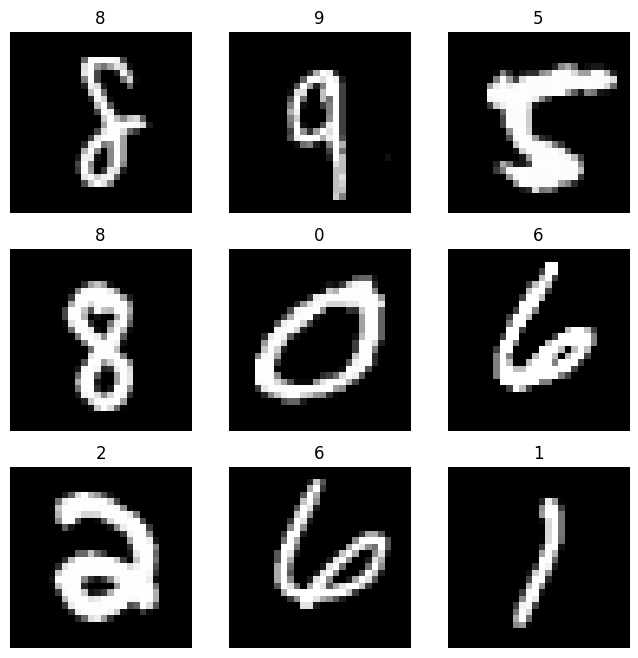

In [5]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Just one batch process

In [6]:
batch_size = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
784*3

2352

In [ ]:
torch.manual_seed(25)
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=3, # No. of filters
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.fc1 = nn.Linear(784*3, 500)
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        #print("Input:",x.shape)
        x = F.relu(self.conv1(x))
        #print("After Conv:",x.shape)
        x = x.reshape(x.shape[0], -1)
        #print("After Flattening:",x.shape)
        x = self.fc1(x)
        #print("After FC1:",x.shape)
        x = self.fc2(x)
        #print("Output:",x.shape)
        return x

Setting the device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cpu')

Hyper-Parameters

In [12]:
in_channels = 1
num_classes = 10
learning_rate = 0.01
num_epochs = 3

Processing of a single batch

In [13]:
model = CNN(in_channels=in_channels, num_classes=num_classes)
train_features, train_labels = next(iter(train_loader))
model(train_features)

Input: torch.Size([1, 1, 28, 28])
After Conv: torch.Size([1, 3, 28, 28])
After Flattening: torch.Size([1, 2352])
After FC1: torch.Size([1, 500])
Output: torch.Size([1, 10])


tensor([[-0.0073, -0.0134,  0.0213, -0.0313, -0.0677,  0.0369, -0.1284, -0.0372,
          0.0155,  0.0253]], grad_fn=<AddmmBackward0>)

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


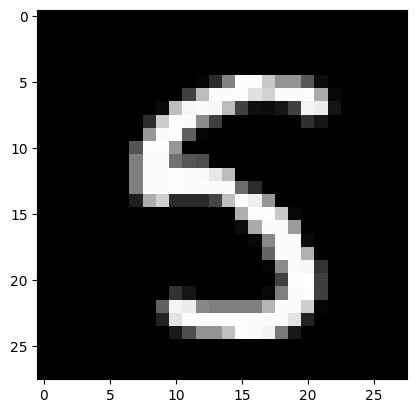

Label: 5


In [12]:
# Display image and label.

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

All the batches

In [36]:
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Initialize the network

In [37]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

Loss and optimizer

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Train Network

In [39]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()





100%|██████████| 3750/3750 [00:13<00:00, 285.97it/s]


##### Check accuracy on training & test to see how good our model

In [40]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


In [41]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 92.61
Accuracy on test set: 91.90
